# Imports

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate # Usar isso?
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve, validation_curve, LearningCurveDisplay, ValidationCurveDisplay



from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report



from sklearn.svm import SVC

import pickle as pkl # to save the model

# Leitura dos dados

In [3]:
# Reading Tokenized Data

data = pd.read_csv('news_tokens.csv')

data.head()

,headline,short_description,mix,category
0,golden globe return nbc januari year,past month hollywood effect boycot globe repor...,past month hollywood effect boycot globe repor...,ENTERTAINMENT
1,biden say forc would defend taiwan china invad,presid issu vow tension china rise,presid issu vow tension china rise biden say f...,POLITICS
2,beauti sad time ukrainian cultur festiv take d...,annual celebr took differ feel russia invas dr...,annual celebr took differ feel russia invas dr...,POLITICS
3,jame cameron say studio releas,avatar director said aspect movi still competi...,avatar director said aspect movi still competi...,ENTERTAINMENT
4,biden say queen death left hole royal famili,presid joe biden london funer queen elizabeth ...,presid joe biden london funer queen elizabeth ...,POLITICS


In [4]:
# Iremos usar apenas o MIX e sua respectiva categoria

# Dropando as colunas que não serão usadas
data = data.drop(columns = ['headline', 'short_description'])
data.tail()

,mix,category
84214,step seren plantat follow narrow damp twisti t...,TRAVEL
84215,ida love say gear birthday may ida thrive dail...,WELLNESS
84216,look back daili column highlight moment fashio...,STYLE & BEAUTY
84217,represent collect diaspora alway thwart need c...,ENTERTAINMENT
84218,soni pictur releas girl dragon tattoo censor b...,ENTERTAINMENT


In [5]:
# Convertendo a coluna de categoria para valores numéricos usando LabelEncoder
le = LabelEncoder()
data['category'] = le.fit_transform(data['category'])

data.tail()

,mix,category
84214,step seren plantat follow narrow damp twisti t...,3
84215,ida love say gear birthday may ida thrive dail...,4
84216,look back daili column highlight moment fashio...,2
84217,represent collect diaspora alway thwart need c...,0
84218,soni pictur releas girl dragon tattoo censor b...,0


# Vetorização de texto

## Por frequência inversa

In [6]:
# Cortando a vetorização para as 10000 palavras mais frequentes ou com min_df = 0.001, ou seja, palavras que aparecem em pelo menos 0.1% dos documentos
inverse_frequency_vectorizer = TfidfVectorizer(max_features=10000, min_df = 0.001)

# Fit the vectorizer to the data

inverse_frequency_vectorizer.fit(data['mix'])

# Transform the data

inverse_frequency_matrix = inverse_frequency_vectorizer.transform(data['mix'])

print(inverse_frequency_matrix.shape)

(84219, 2625)


# Separação dos dados em treino e teste

In [7]:
# 80% dos dados para treino e validacao com kfold = 5 e 20% para teste de forma estratificada (mesma proporção de classes)

X_train_val, X_test, y_train_val, y_test = train_test_split(inverse_frequency_matrix, data['category'], test_size=0.2, random_state=42, stratify=data['category'])

print(X_train_val.shape, X_test.shape)

(67375, 2625) (16844, 2625)


# Regressão Logística

In [54]:
# Regressão Logística

log = LogisticRegression(max_iter=2000, multi_class='multinomial', n_jobs=-1)

# Grid Search

param_grid = {'C': [0.5, 1, 1.5, 2, 2.5, 3],
              'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']} #  Unicos que podem ser usados com multiclass

grid_search = GridSearchCV(estimator=log, param_grid=param_grid, cv=5, verbose=2, return_train_score=True, n_jobs=-1)

grid_search.fit(X_train_val, y_train_val)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..................................C=0.5, solver=sag; total time=   0.8s
[CV] END ..................................C=0.5, solver=sag; total time=   0.9s
[CV] END ..................................C=0.5, solver=sag; total time=   1.0s
[CV] END ............................C=0.5, solver=newton-cg; total time=   1.3s
[CV] END ............................C=0.5, solver=newton-cg; total time=   1.3s
[CV] END ............................C=0.5, solver=newton-cg; total time=   1.3s
[CV] END ............................C=0.5, solver=newton-cg; total time=   1.4s
[CV] END ............................C=0.5, solver=newton-cg; total time=   1.5s
[CV] END ..................................C=0.5, solver=sag; total time=   0.8s
[CV] END .................................C=0.5, solver=saga; total time=   0.8s
[CV] END ..................................C=0.5, solver=sag; total time=   0.9s
[CV] END .................................C=0.5

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=2000,
                                          multi_class='multinomial',
                                          n_jobs=-1),
             n_jobs=-1,
             param_grid={'C': [0.5, 1, 1.5, 2, 2.5, 3],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
             return_train_score=True, verbose=2)

In [55]:
# CV Results

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.353270,0.058340,0.003863,0.000317,0.5,newton-cg,"{'C': 0.5, 'solver': 'newton-cg'}",0.879109,0.881187,0.882968,...,0.880787,0.001656,22,0.901299,0.900816,0.899814,0.900835,0.900798,0.900712,0.000486
1,0.878639,0.093910,0.003978,0.000886,0.5,sag,"{'C': 0.5, 'solver': 'sag'}",0.879109,0.881187,0.882968,...,0.880787,0.001656,22,0.901299,0.900835,0.899814,0.900835,0.900798,0.900716,0.000487
2,0.838741,0.035893,0.003365,0.000510,0.5,saga,"{'C': 0.5, 'solver': 'saga'}",0.879109,0.881187,0.882968,...,0.880801,0.001638,21,0.901262,0.900853,0.899833,0.900835,0.900798,0.900716,0.000473
3,2.277958,0.169222,0.003712,0.001322,0.5,lbfgs,"{'C': 0.5, 'solver': 'lbfgs'}",0.879109,0.881187,0.882968,...,0.880787,0.001656,22,0.901317,0.900779,0.899814,0.900816,0.900835,0.900712,0.000490
4,1.702533,0.055986,0.005554,0.001037,1,newton-cg,"{'C': 1, 'solver': 'newton-cg'}",0.881410,0.883043,0.887199,...,0.883607,0.002027,18,0.909685,0.909759,0.909184,0.909462,0.908609,0.909340,0.000417
5,0.907908,0.062152,0.003882,0.000425,1,sag,"{'C': 1, 'solver': 'sag'}",0.881410,0.883043,0.887199,...,0.883607,0.002027,18,0.909666,0.909759,0.909184,0.909462,0.908609,0.909336,0.000414
6,0.891014,0.059032,0.004690,0.001735,1,saga,"{'C': 1, 'solver': 'saga'}",0.881336,0.882968,0.887199,...,0.883607,0.002042,18,0.909796,0.909759,0.909221,0.909499,0.908646,0.909384,0.000423
7,2.728726,0.163229,0.003469,0.000853,1,lbfgs,"{'C': 1, 'solver': 'lbfgs'}",0.881410,0.883043,0.887199,...,0.883622,0.002017,17,0.909703,0.909777,0.909165,0.909462,0.908646,0.909351,0.000412
8,1.518158,0.091297,0.003872,0.000864,1.5,newton-cg,"{'C': 1.5, 'solver': 'newton-cg'}",0.880891,0.884750,0.887199,...,0.884438,0.002055,6,0.914286,0.913766,0.913284,0.913729,0.912375,0.913488,0.000641
9,0.925432,0.081252,0.003674,0.000571,1.5,sag,"{'C': 1.5, 'solver': 'sag'}",0.880891,0.884750,0.887199,...,0.884438,0.002055,6,0.914304,0.913766,0.913265,0.913729,0.912375,0.913488,0.000647


In [56]:
# Melhores parâmetros encontrados pelo Grid Search
print(grid_search.best_params_)

# Melhor score encontrado pelo Grid Search
print(grid_search.best_score_)

# Melhor modelo encontrado pelo Grid Search
best_model = grid_search.best_estimator_
print(best_model)



{'C': 2, 'solver': 'saga'}
0.8846011131725419
LogisticRegression(C=2, max_iter=2000, multi_class='multinomial', n_jobs=-1,
                   solver='saga')


Treinando o modelo com os melhores parâmetros encontrados:
LogisticRegression(C=2, max_iter=2000, multi_class='multinomial', n_jobs=-1,
                   solver='saga')
--------------------------------------------------
F1 Score: 0.865202072040397
Test Accuracy: 0.8813358070500927
Train Accuracy: 0.9176437847866419
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2364
           1       0.92      0.94      0.93      5188
           2       0.89      0.84      0.87      1546
           3       0.87      0.81      0.84      1507
           4       0.85      0.89      0.87      2870

    accuracy                           0.88     13475
   macro avg       0.87      0.86      0.87     13475
weighted avg       0.88      0.88      0.88     13475



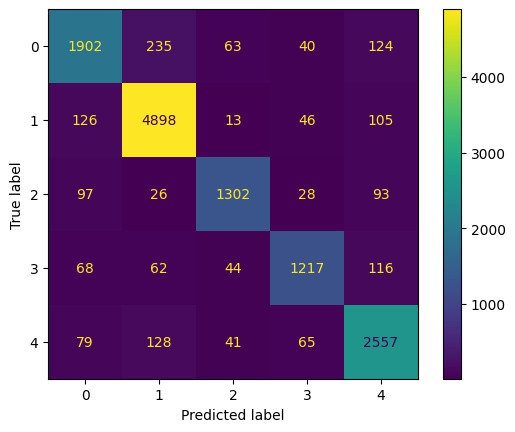

--------------------------------------------------
F1 Score: 0.8694983037748903
Test Accuracy: 0.8845269016697588
Train Accuracy: 0.9163450834879406
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2364
           1       0.92      0.94      0.93      5188
           2       0.89      0.84      0.87      1547
           3       0.86      0.82      0.84      1506
           4       0.87      0.90      0.88      2870

    accuracy                           0.88     13475
   macro avg       0.88      0.86      0.87     13475
weighted avg       0.88      0.88      0.88     13475



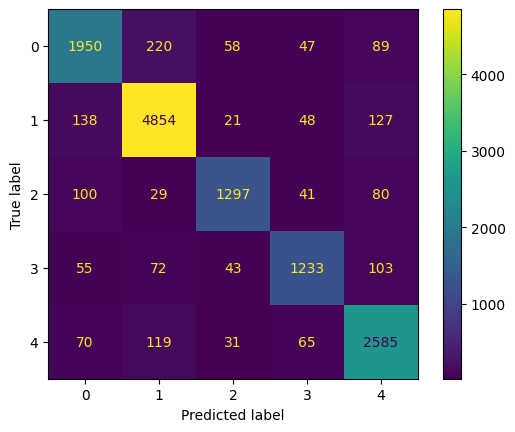

--------------------------------------------------
F1 Score: 0.8650040525658469
Test Accuracy: 0.8807421150278293
Train Accuracy: 0.9168831168831169
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      2363
           1       0.92      0.94      0.93      5189
           2       0.91      0.83      0.87      1547
           3       0.87      0.81      0.84      1507
           4       0.86      0.90      0.88      2869

    accuracy                           0.88     13475
   macro avg       0.87      0.86      0.87     13475
weighted avg       0.88      0.88      0.88     13475



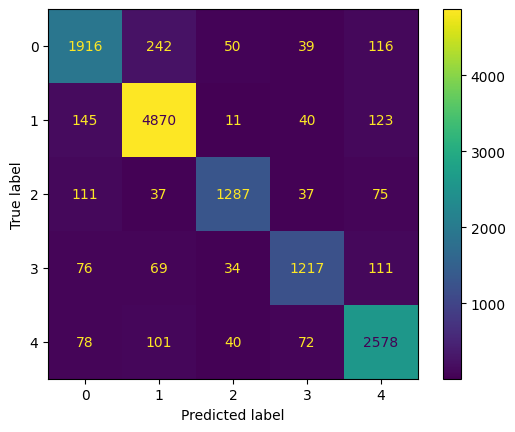

--------------------------------------------------
F1 Score: 0.8665312903084873
Test Accuracy: 0.8819294990723562
Train Accuracy: 0.916808905380334
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      2363
           1       0.92      0.94      0.93      5188
           2       0.89      0.84      0.86      1547
           3       0.86      0.82      0.84      1507
           4       0.86      0.90      0.88      2870

    accuracy                           0.88     13475
   macro avg       0.87      0.86      0.87     13475
weighted avg       0.88      0.88      0.88     13475



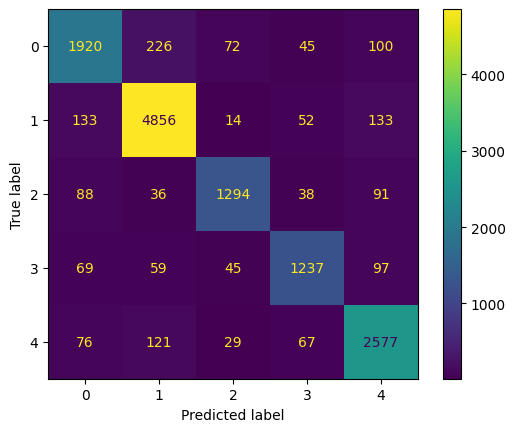

--------------------------------------------------
F1 Score: 0.8687098150953252
Test Accuracy: 0.8833395176252319
Train Accuracy: 0.9169202226345083
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      2363
           1       0.92      0.93      0.93      5188
           2       0.89      0.84      0.86      1547
           3       0.87      0.82      0.85      1507
           4       0.86      0.90      0.88      2870

    accuracy                           0.88     13475
   macro avg       0.87      0.86      0.87     13475
weighted avg       0.88      0.88      0.88     13475



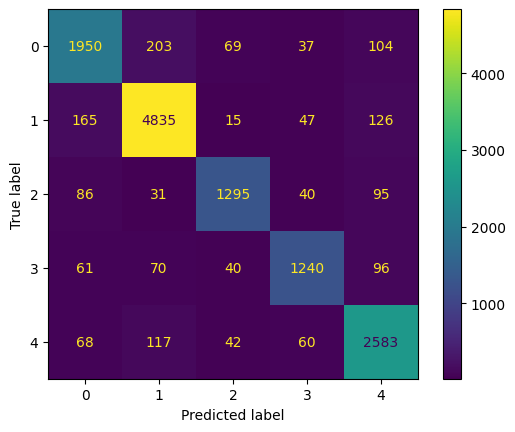

--------------------------------------------------


In [57]:
# Usando os melhores parâmetros para treinar o modelo e avaliar no conjunto de teste e aplicar cross validation

log = best_model
print('Treinando o modelo com os melhores parâmetros encontrados:')
print(best_model)
print('-'*50)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_train_val, y_train_val):

    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    
    log.fit(X_train, y_train)
    y_pred = log.predict(X_val)
    print('F1 Score:', f1_score(y_val, y_pred, average='macro'))
    print('Test Accuracy:', accuracy_score(y_val, y_pred))
    print('Train Accuracy:', accuracy_score(y_train, log.predict(X_train)))
    print(classification_report(y_val, y_pred))

    # Matriz de Confusão
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    print('-'*50)

In [109]:
# Cross Validation (Outra forma de fazer o mesmo que o código acima)

cv_results = cross_validate(log, X_train_val, y_train_val, cv=5, n_jobs=-1, return_train_score=True)
display(pd.DataFrame(cv_results))

print('Test Accuracy:', cv_results['test_score'].mean())
print('Train Accuracy:', cv_results['train_score'].mean())

,fit_time,score_time,test_score,train_score
0,0.687025,0.002323,0.880223,0.917532
1,0.769546,0.001769,0.884453,0.917087
2,0.749872,0.001829,0.888534,0.916030
3,0.784153,0.001842,0.884601,0.916883
4,0.740431,0.002064,0.885343,0.915417


Test Accuracy: 0.8846307977736549
Train Accuracy: 0.9165899814471242


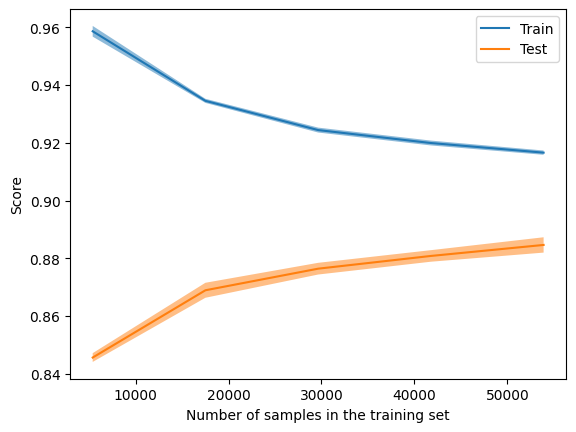

In [58]:
# Curva de Aprendizado

LearningCurveDisplay.from_estimator(log, X_train_val, y_train_val, cv=5, n_jobs=-1)
plt.show()


F1 Score: 0.8699263605479146
Test Accuracy: 0.8849441937782
Train Accuracy: 0.9137365491651206
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2955
           1       0.92      0.94      0.93      6485
           2       0.90      0.83      0.86      1933
           3       0.87      0.82      0.85      1883
           4       0.87      0.90      0.88      3588

    accuracy                           0.88     16844
   macro avg       0.88      0.86      0.87     16844
weighted avg       0.88      0.88      0.88     16844



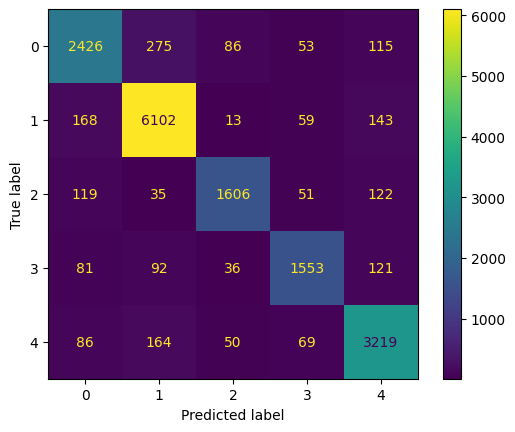

In [59]:
# Testando no conjunto de teste

log.fit(X_train_val, y_train_val)
y_pred = log.predict(X_test)

print('F1 Score:', f1_score(y_test, y_pred, average='macro')) # Macro vs Weighted vs Micro
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Train Accuracy:', accuracy_score(y_train_val, log.predict(X_train_val)))
print(classification_report(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [60]:
# Classification Report com o nome das classes
classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

{'ENTERTAINMENT': {'precision': 0.8423611111111111,
  'recall': 0.8209813874788494,
  'f1-score': 0.8315338474721509,
  'support': 2955.0},
 'POLITICS': {'precision': 0.915116976604679,
  'recall': 0.940940632228219,
  'f1-score': 0.9278491598874781,
  'support': 6485.0},
 'STYLE & BEAUTY': {'precision': 0.8967057509771078,
  'recall': 0.8308329022245214,
  'f1-score': 0.8625134264232008,
  'support': 1933.0},
 'TRAVEL': {'precision': 0.8700280112044818,
  'recall': 0.8247477429633564,
  'f1-score': 0.846782988004362,
  'support': 1883.0},
 'WELLNESS': {'precision': 0.8653225806451613,
  'recall': 0.8971571906354515,
  'f1-score': 0.880952380952381,
  'support': 3588.0},
 'accuracy': 0.8849441937782,
 'macro avg': {'precision': 0.8779068861085083,
  'recall': 0.8629319711060797,
  'f1-score': 0.8699263605479146,
  'support': 16844.0},
 'weighted avg': {'precision': 0.8845929148483915,
  'recall': 0.8849441937782,
  'f1-score': 0.8844022965860785,
  'support': 16844.0}}

In [62]:
# Salvando o modelo

pkl.dump(log, open('logistic_regression_model.pkl', 'wb'))

# Floresta Aleatória

In [133]:
# Random Forest

rf = RandomForestClassifier(n_jobs=-1, random_state=42) # n_jobs=-1 para usar todos os cores do processador!

# Grid Search

param_grid = {'n_estimators': [25, 50, 100],
                'min_samples_leaf': [2, 5, 10],
                'criterion': ['gini', 'entropy'],
                'max_features': ['sqrt', 'log2'],
            } 

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, return_train_score=True, n_jobs=-1, scoring='f1_macro') # Evitar overfitting

grid_search.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=gini, max_features=sqrt, min_samples_leaf=2, n_estimators=25; total time=   6.0s
[CV] END criterion=gini, max_features=sqrt, min_samples_leaf=2, n_estimators=25; total time=   6.1s
[CV] END criterion=gini, max_features=sqrt, min_samples_leaf=2, n_estimators=25; total time=   6.3s
[CV] END criterion=gini, max_features=sqrt, min_samples_leaf=2, n_estimators=25; total time=   6.3s
[CV] END criterion=gini, max_features=sqrt, min_samples_leaf=2, n_estimators=25; total time=   6.3s
[CV] END criterion=gini, max_features=sqrt, min_samples_leaf=2, n_estimators=50; total time=  11.8s
[CV] END criterion=gini, max_features=sqrt, min_samples_leaf=2, n_estimators=50; total time=  11.7s
[CV] END criterion=gini, max_features=sqrt, min_samples_leaf=2, n_estimators=50; total time=  11.8s
[CV] END criterion=gini, max_features=sqrt, min_samples_leaf=5, n_estimators=25; total time=   4.0s
[CV] END criterion=gini, max_features=

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [2, 5, 10],
                         'n_estimators': [25, 50, 100]},
             return_train_score=True, scoring='f1_macro', verbose=2)

In [134]:
# CV Results

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.134888,0.141341,0.064038,0.025545,gini,sqrt,2,25,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.798502,...,0.801309,0.003750,13,0.910209,0.909019,0.908806,0.910774,0.908322,0.909426,0.000917
1,11.757600,0.127389,0.106300,0.015076,gini,sqrt,2,50,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.800761,...,0.803813,0.004399,10,0.912293,0.911727,0.912710,0.913457,0.912453,0.912528,0.000565
2,23.501023,0.350710,0.360960,0.052486,gini,sqrt,2,100,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.801615,...,0.805538,0.004338,9,0.913819,0.914209,0.914462,0.915921,0.915626,0.914807,0.000820
3,4.000607,0.176709,0.040368,0.002932,gini,sqrt,5,25,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.790898,...,0.793198,0.004008,24,0.833883,0.831124,0.829574,0.831930,0.828387,0.830980,0.001900
4,7.366252,0.085054,0.077396,0.013807,gini,sqrt,5,50,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.790578,...,0.794676,0.004999,21,0.835035,0.833475,0.831717,0.832281,0.830651,0.832632,0.001508
5,14.526293,0.260682,0.262427,0.050399,gini,sqrt,5,100,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.791739,...,0.795838,0.004285,19,0.836570,0.834901,0.833173,0.834235,0.831376,0.834051,0.001734
6,3.086870,0.113461,0.038377,0.003425,gini,sqrt,10,25,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.775910,...,0.779800,0.004116,35,0.802242,0.802436,0.799191,0.800836,0.797603,0.800462,0.001844
7,5.652596,0.049274,0.064767,0.007709,gini,sqrt,10,50,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.777452,...,0.780971,0.004318,33,0.804310,0.803393,0.800407,0.801820,0.799837,0.801953,0.001704
8,10.879354,0.281432,0.198474,0.049783,gini,sqrt,10,100,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.779092,...,0.783291,0.004397,31,0.806305,0.804732,0.802660,0.803003,0.800727,0.803485,0.001899
9,2.296545,0.041842,0.052310,0.009327,gini,log2,2,25,"{'criterion': 'gini', 'max_features': 'log2', ...",0.813932,...,0.812566,0.003777,5,0.873994,0.874163,0.873287,0.873538,0.873232,0.873643,0.000374


In [135]:
# Melhores parâmetros encontrados pelo Grid Search
print(grid_search.best_params_)

# Melhor score encontrado pelo Grid Search
print(grid_search.best_score_)

# Melhor modelo encontrado pelo Grid Search
best_model = grid_search.best_estimator_
print(best_model)


{'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 100}
0.821953308804563
RandomForestClassifier(max_features='log2', min_samples_leaf=2, n_jobs=-1,
                       random_state=42)


Treinando o modelo com os melhores parâmetros encontrados:
RandomForestClassifier(max_features='log2', min_samples_leaf=2, n_jobs=-1,
                       random_state=42)
F1 Score: 0.8207061163654494
Test Accuracy: 0.845491651205937
Train Accuracy: 0.8986827458256029
              precision    recall  f1-score   support

           0       0.84      0.71      0.77      2364
           1       0.86      0.95      0.90      5188
           2       0.87      0.80      0.83      1546
           3       0.89      0.66      0.76      1507
           4       0.79      0.89      0.84      2870

    accuracy                           0.85     13475
   macro avg       0.85      0.80      0.82     13475
weighted avg       0.85      0.85      0.84     13475



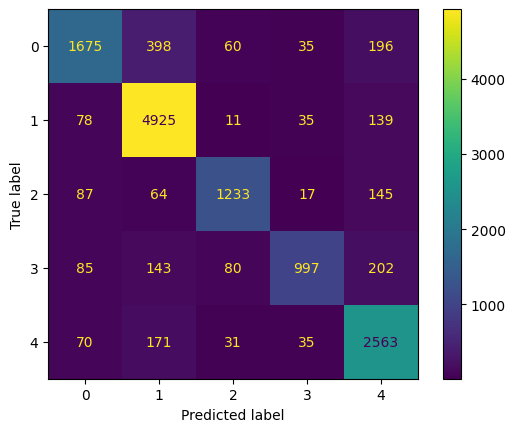

F1 Score: 0.8179761321668139
Test Accuracy: 0.8437847866419295
Train Accuracy: 0.8991836734693878
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      2364
           1       0.86      0.95      0.90      5188
           2       0.86      0.79      0.82      1547
           3       0.88      0.65      0.75      1506
           4       0.78      0.89      0.83      2870

    accuracy                           0.84     13475
   macro avg       0.85      0.80      0.82     13475
weighted avg       0.85      0.84      0.84     13475



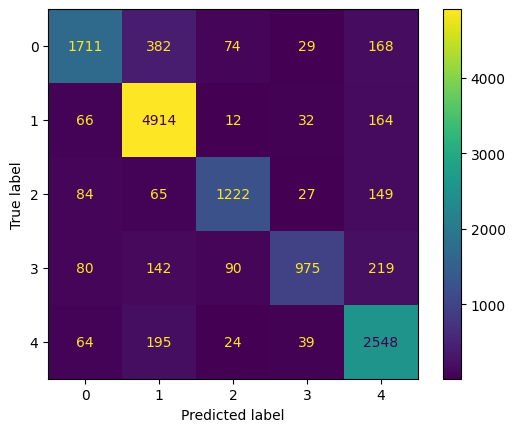

F1 Score: 0.8198882482288692
Test Accuracy: 0.8449721706864564
Train Accuracy: 0.8976252319109462
              precision    recall  f1-score   support

           0       0.84      0.71      0.77      2363
           1       0.87      0.95      0.90      5189
           2       0.88      0.79      0.83      1547
           3       0.88      0.66      0.75      1507
           4       0.78      0.90      0.84      2869

    accuracy                           0.84     13475
   macro avg       0.85      0.80      0.82     13475
weighted avg       0.85      0.84      0.84     13475



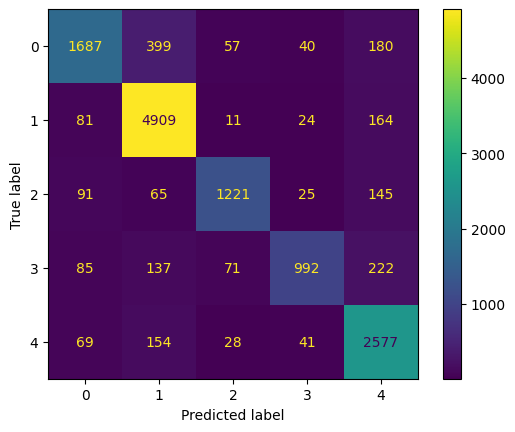

F1 Score: 0.8176675998656702
Test Accuracy: 0.8420037105751391
Train Accuracy: 0.8983673469387755
              precision    recall  f1-score   support

           0       0.84      0.72      0.77      2363
           1       0.87      0.94      0.90      5188
           2       0.87      0.79      0.83      1547
           3       0.87      0.67      0.75      1507
           4       0.78      0.89      0.83      2870

    accuracy                           0.84     13475
   macro avg       0.85      0.80      0.82     13475
weighted avg       0.84      0.84      0.84     13475



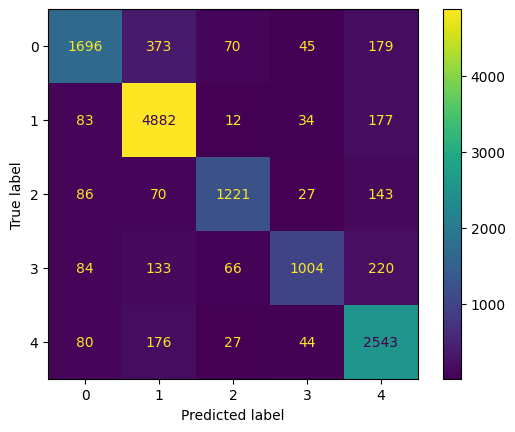

F1 Score: 0.8247481081230423
Test Accuracy: 0.849721706864564
Train Accuracy: 0.8983487940630798
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      2363
           1       0.87      0.95      0.91      5188
           2       0.87      0.79      0.83      1547
           3       0.90      0.66      0.76      1507
           4       0.78      0.90      0.84      2870

    accuracy                           0.85     13475
   macro avg       0.86      0.81      0.82     13475
weighted avg       0.85      0.85      0.85     13475



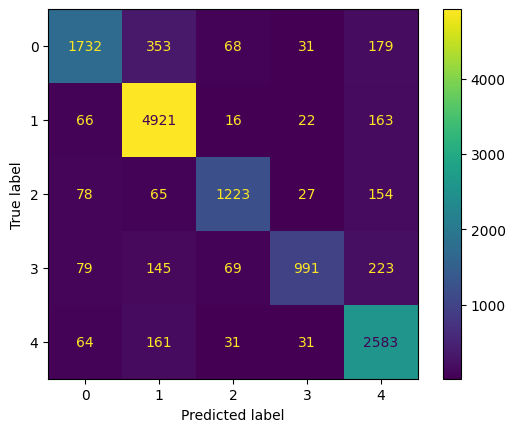

In [136]:
# Usando os melhores parâmetros para treinar o modelo e avaliar no conjunto de teste e aplicar cross validation

# n_estimators = grid_search.best_params_['n_estimators']
# max_depth = grid_search.best_params_['max_depth']
# max_features = grid_search.best_params_['max_features']
# criterion = grid_search.best_params_['criterion']

# n_estimators = 300 # Nao influencia muito
# max_depth = 200 # Importante, quanto maior melhor
# max_features = 'log2'
# criterion = 'gini'

# rf = RandomForestClassifier(max_features=max_features, criterion=criterion, n_jobs=-1, random_state=42)
# rf = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=42, min_samples_leaf=10)

rf = best_model
print('Treinando o modelo com os melhores parâmetros encontrados:')
print(best_model)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    print('F1 Score:', f1_score(y_val, y_pred, average='macro'))
    print('Test Accuracy:', accuracy_score(y_val, y_pred))
    print('Train Accuracy:', accuracy_score(y_train, rf.predict(X_train)))
    print(classification_report(y_val, y_pred))

    # Matriz de Confusão
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [137]:
# Cross Validation (Outra forma de fazer o mesmo que o código acima)
# rf = RandomForestClassifier(max_depth=30, n_estimators=25, n_jobs=-1, random_state=42) # Melhores parâmetros encontrados
cv_results = cross_validate(rf, X_train_val, y_train_val, cv=5, n_jobs=-1, return_train_score=True)
display(pd.DataFrame(cv_results))

print('Test Accuracy:', cv_results['test_score'].mean())
print('Train Accuracy:', cv_results['train_score'].mean())

,fit_time,score_time,test_score,train_score
0,4.358112,0.169917,0.845195,0.899814
1,4.622748,0.189558,0.844082,0.898256
2,4.874427,0.185368,0.851132,0.896586
3,4.634995,0.204904,0.842597,0.899184
4,4.821903,0.225959,0.849499,0.898942


Test Accuracy: 0.8465009276437849
Train Accuracy: 0.898556586270872


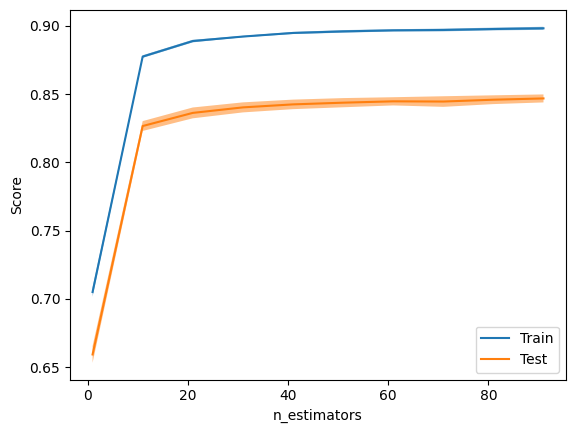

In [139]:
# Curva de Aprendizado

ValidationCurveDisplay.from_estimator(rf, X_train_val, y_train_val, param_name='n_estimators', cv=5, n_jobs=-1, param_range=np.arange(1, 100, 10))
plt.show()


F1 Score: 0.828881193661666
Test Accuracy: 0.852172880550938
Train Accuracy: 0.9004081632653061
              precision    recall  f1-score   support

           0       0.84      0.72      0.77      2955
           1       0.87      0.95      0.91      6485
           2       0.88      0.79      0.83      1933
           3       0.90      0.69      0.78      1883
           4       0.80      0.90      0.85      3588

    accuracy                           0.85     16844
   macro avg       0.86      0.81      0.83     16844
weighted avg       0.85      0.85      0.85     16844



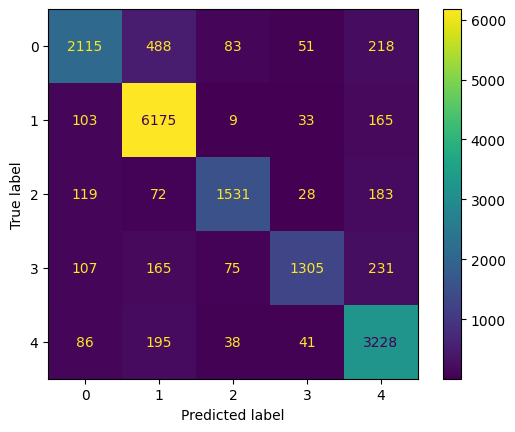

In [140]:
# Testando no conjunto de teste

rf.fit(X_train_val, y_train_val)
y_pred = rf.predict(X_test)

print('F1 Score:', f1_score(y_test, y_pred, average='macro')) # Macro vs Weighted vs Micro
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Train Accuracy:', accuracy_score(y_train_val, rf.predict(X_train_val)))
print(classification_report(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [141]:
# Classification Report
classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

{'ENTERTAINMENT': {'precision': 0.8359683794466403,
  'recall': 0.7157360406091371,
  'f1-score': 0.7711941659070192,
  'support': 2955.0},
 'POLITICS': {'precision': 0.8703312191684285,
  'recall': 0.9521973785659213,
  'f1-score': 0.9094256259204713,
  'support': 6485.0},
 'STYLE & BEAUTY': {'precision': 0.8819124423963134,
  'recall': 0.7920331091567512,
  'f1-score': 0.8345598255655492,
  'support': 1933.0},
 'TRAVEL': {'precision': 0.8950617283950617,
  'recall': 0.6930430164630909,
  'f1-score': 0.7812032325651004,
  'support': 1883.0},
 'WELLNESS': {'precision': 0.8019875776397516,
  'recall': 0.8996655518394648,
  'f1-score': 0.8480231183501905,
  'support': 3588.0},
 'accuracy': 0.852172880550938,
 'macro avg': {'precision': 0.8570522694092391,
  'recall': 0.810535019326873,
  'f1-score': 0.828881193661666,
  'support': 16844.0},
 'weighted avg': {'precision': 0.8538383953849137,
  'recall': 0.852172880550938,
  'f1-score': 0.8491700737786909,
  'support': 16844.0}}

['gop', 'democrat', 'style', 'republican', 'presid', 'fashion', 'travel', 'donald', 'photo', 'trump']


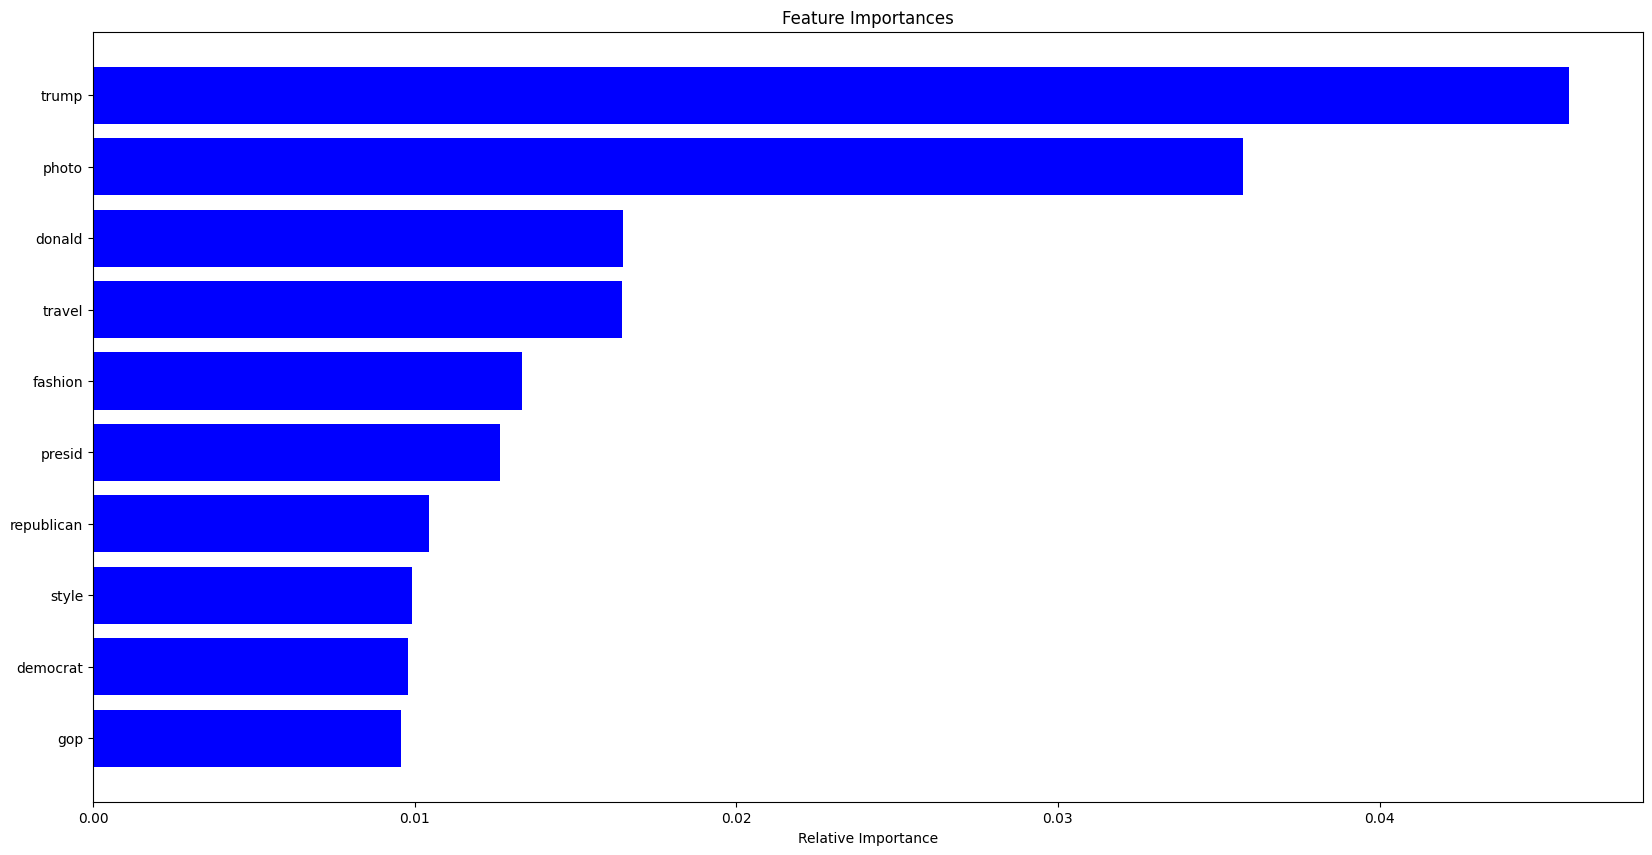

In [142]:
# Plotando a importância das features no modelo (10 mais importantes) 
# (https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

features = inverse_frequency_vectorizer.get_feature_names_out()
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]

top_features = [features[i] for i in indices]

print(top_features)

plt.figure(figsize=(20, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), top_features)
plt.xlabel('Relative Importance')
plt.show()

# sns.barplot(x=rf.feature_importances_, y=inverse_frequency_vectorizer.get_feature_names_out())


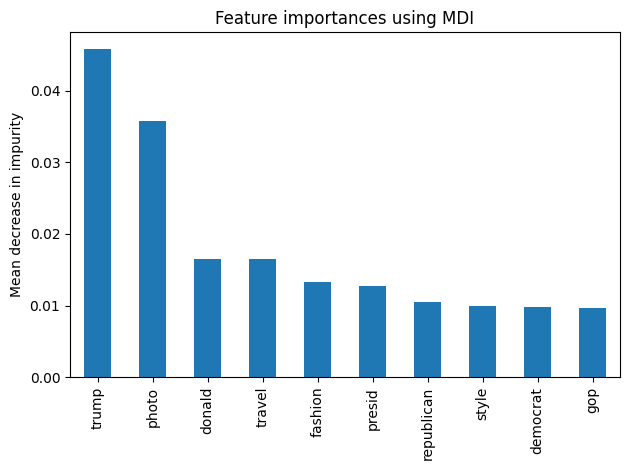

In [143]:
# Plotando a importância das features no modelo (10 mais importantes) usando outra abordagem

forest_importances = pd.Series(rf.feature_importances_, index=inverse_frequency_vectorizer.get_feature_names_out())
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.nlargest(10).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

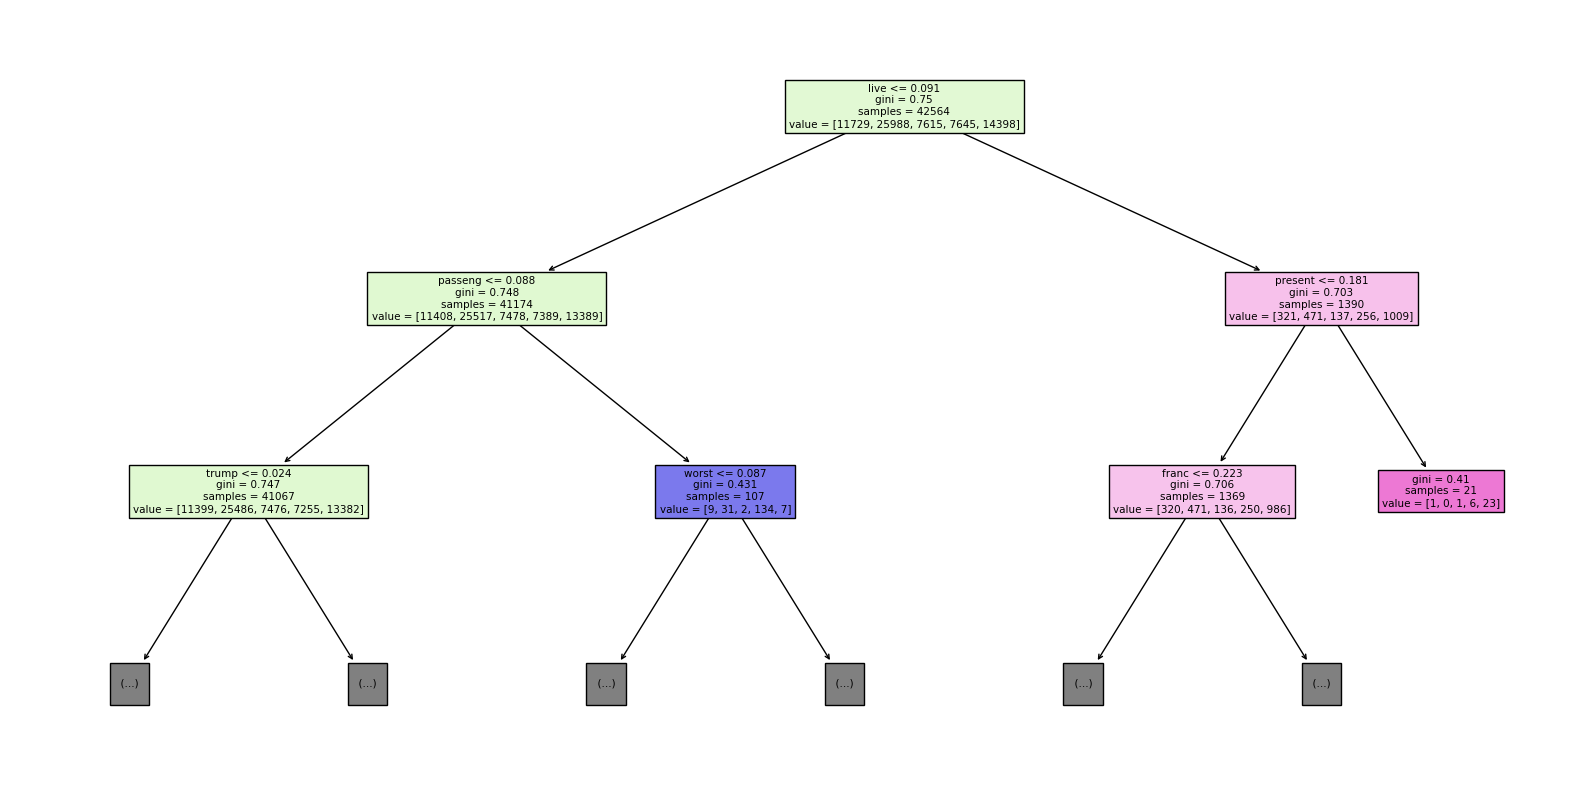

In [156]:
# Mostrando a arvore de decisão

from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], max_depth=2, feature_names=inverse_frequency_vectorizer.get_feature_names_out(), filled=True)
plt.show()

In [157]:
# Salvando o modelo

pkl.dump(rf, open('random_forest_model.pkl', 'wb') )

# SVM (Máquina de Vetores de Suporte)

In [158]:
# Support Vector Machine Classifier 
# Esse modelo é muito pesado para ser treinado com o dataset completo, complexidade O(n^3)!
# Talvez seja necessário usar uma biblioteca como o PyTorch ou TensorFlow para treinar esse modelo

svc = SVC(random_state=42, max_iter=1000)

# Grid Search

param_grid = {'C': [0.1, 1, 10],
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
            }

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, verbose=2, return_train_score=True, n_jobs=-1, scoring='f1_macro') # Evitar overfitting

grid_search.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
# Melhores parâmetros encontrados pelo Grid Search
print(grid_search.best_params_)

In [ ]:
# Usando os melhores parâmetros para treinar o modelo e avaliar no conjunto de teste e aplicar cross validation


# Rede Neural

In [159]:
# Neural Network Classifier
# Talvez seja necessário usar uma biblioteca como o PyTorch ou TensorFlow para treinar esse modelo
# Vai ter que ser treinado em um ambiente com GPU

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42, max_iter=1000, early_stopping=True)

# Grid Search

param_grid = {'hidden_layer_sizes': [(10,), (50,), (100,)],
                'activation': ['relu', 'tanh', 'logistic'],
                'solver': ['adam', 'sgd']
            }

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, verbose=2, return_train_score=True, n_jobs=-1, scoring='f1_macro') # Evitar overfitting

grid_search.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END activation=relu, hidden_layer_sizes=(10,), solver=sgd; total time=   1.4s
[CV] END activation=relu, hidden_layer_sizes=(10,), solver=sgd; total time=   1.4s
[CV] END activation=relu, hidden_layer_sizes=(10,), solver=sgd; total time=   1.4s
[CV] END activation=relu, hidden_layer_sizes=(10,), solver=adam; total time=   2.3s
[CV] END activation=relu, hidden_layer_sizes=(10,), solver=adam; total time=   2.4s
[CV] END activation=relu, hidden_layer_sizes=(10,), solver=adam; total time=   2.4s
[CV] END activation=relu, hidden_layer_sizes=(10,), solver=adam; total time=   2.9s
[CV] END activation=relu, hidden_layer_sizes=(10,), solver=sgd; total time=   1.4s
[CV] END activation=relu, hidden_layer_sizes=(10,), solver=adam; total time=   2.9s
[CV] END activation=relu, hidden_layer_sizes=(10,), solver=sgd; total time=   1.5s
[CV] END activation=relu, hidden_layer_sizes=(50,), solver=sgd; total time=   7.6s
[CV] END activation=r

GridSearchCV(cv=5,
             estimator=MLPClassifier(early_stopping=True, max_iter=1000,
                                     random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [(10,), (50,), (100,)],
                         'solver': ['adam', 'sgd']},
             return_train_score=True, scoring='f1_macro', verbose=2)

In [160]:
# CV Results

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_solver,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.561117,0.246476,0.009784,0.002099,relu,"(10,)",adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.867820,0.869343,...,0.868463,0.002702,4,0.902024,0.904357,0.893520,0.890807,0.899183,0.897978,0.005095
1,1.386216,0.031412,0.008167,0.001550,relu,"(10,)",sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.111193,0.111193,...,0.111196,0.000006,11,0.111197,0.111197,0.111193,0.111197,0.111197,0.111196,0.000002
2,11.577110,0.470469,0.029015,0.002114,relu,"(50,)",adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.868371,0.865590,...,0.868222,0.002703,5,0.907813,0.894720,0.893978,0.896245,0.884825,0.895516,0.007335
3,7.964698,0.253182,0.031142,0.009986,relu,"(50,)",sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.111193,0.111193,...,0.111196,0.000006,11,0.111197,0.111197,0.111193,0.111197,0.111197,0.111196,0.000002
4,31.220298,0.900328,0.032686,0.008009,relu,"(100,)",adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.865868,0.866766,...,0.866214,0.001312,9,0.894863,0.893932,0.872255,0.893828,0.893242,0.889624,0.008700
5,22.212500,1.832930,0.034570,0.008626,relu,"(100,)",sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.111193,0.111193,...,0.111196,0.000006,11,0.111197,0.111197,0.111193,0.111197,0.111197,0.111196,0.000002
6,3.476333,0.435476,0.010790,0.002174,tanh,"(10,)",adam,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.865726,0.868528,...,0.868207,0.002596,6,0.910690,0.904650,0.893188,0.898866,0.898830,0.901245,0.005953
7,1.611153,0.070945,0.009189,0.003376,tanh,"(10,)",sgd,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.111193,0.111193,...,0.111196,0.000006,11,0.111197,0.111197,0.111193,0.111197,0.111197,0.111196,0.000002
8,13.156346,0.475772,0.021377,0.006531,tanh,"(50,)",adam,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.867330,0.865271,...,0.868176,0.003475,7,0.903050,0.894508,0.900815,0.895299,0.893884,0.897511,0.003706
9,8.715189,0.241701,0.018277,0.003330,tanh,"(50,)",sgd,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.111193,0.111193,...,0.111196,0.000006,11,0.111197,0.111197,0.111193,0.111197,0.111197,0.111196,0.000002


In [161]:
# Melhores parâmetros encontrados pelo Grid Search
print(grid_search.best_params_)

# Melhor score encontrado pelo Grid Search
print(grid_search.best_score_)

# Melhor modelo encontrado pelo Grid Search
best_model = grid_search.best_estimator_
print(best_model)


{'activation': 'logistic', 'hidden_layer_sizes': (10,), 'solver': 'adam'}
0.870110914181607
MLPClassifier(activation='logistic', early_stopping=True,
              hidden_layer_sizes=(10,), max_iter=1000, random_state=42)


Treinando o modelo com os melhores parâmetros encontrados:
MLPClassifier(activation='logistic', early_stopping=True,
              hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
--------------------------------------------------
F1 Score: 0.865723518977541
Test Accuracy: 0.8817810760667903
Train Accuracy: 0.9029313543599258
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      2364
           1       0.92      0.94      0.93      5188
           2       0.89      0.84      0.86      1546
           3       0.88      0.81      0.84      1507
           4       0.86      0.90      0.88      2870

    accuracy                           0.88     13475
   macro avg       0.87      0.86      0.87     13475
weighted avg       0.88      0.88      0.88     13475



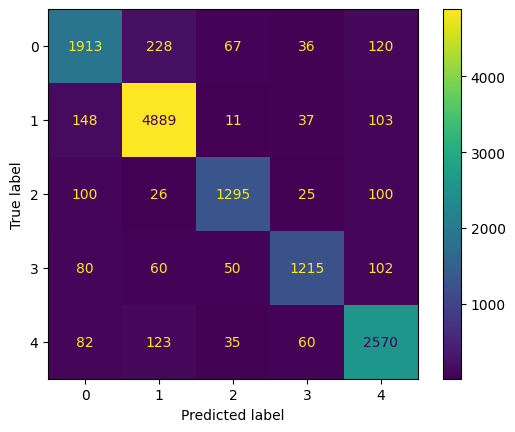

--------------------------------------------------
F1 Score: 0.8684195963047159
Test Accuracy: 0.8835621521335807
Train Accuracy: 0.9175324675324675
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2364
           1       0.92      0.93      0.93      5188
           2       0.88      0.85      0.86      1547
           3       0.85      0.83      0.84      1506
           4       0.87      0.89      0.88      2870

    accuracy                           0.88     13475
   macro avg       0.87      0.86      0.87     13475
weighted avg       0.88      0.88      0.88     13475



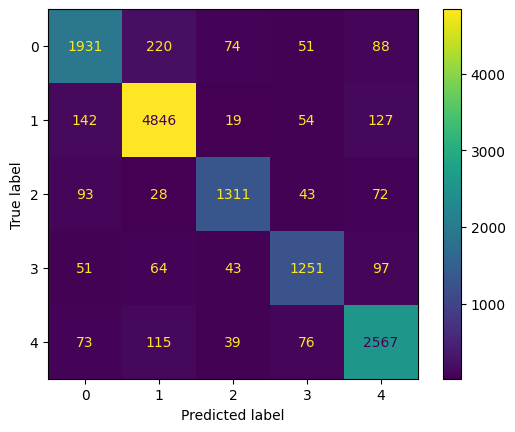

--------------------------------------------------
F1 Score: 0.8685311025396338
Test Accuracy: 0.8837847866419295
Train Accuracy: 0.9138404452690166
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      2363
           1       0.92      0.94      0.93      5189
           2       0.90      0.84      0.87      1547
           3       0.86      0.83      0.84      1507
           4       0.87      0.90      0.88      2869

    accuracy                           0.88     13475
   macro avg       0.87      0.86      0.87     13475
weighted avg       0.88      0.88      0.88     13475



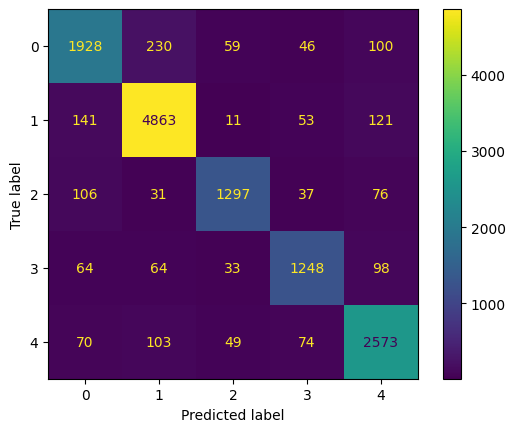

--------------------------------------------------
F1 Score: 0.8718424145919021
Test Accuracy: 0.8860111317254175
Train Accuracy: 0.9084230055658628
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      2363
           1       0.92      0.94      0.93      5188
           2       0.89      0.84      0.87      1547
           3       0.87      0.84      0.85      1507
           4       0.87      0.90      0.89      2870

    accuracy                           0.89     13475
   macro avg       0.88      0.87      0.87     13475
weighted avg       0.89      0.89      0.89     13475



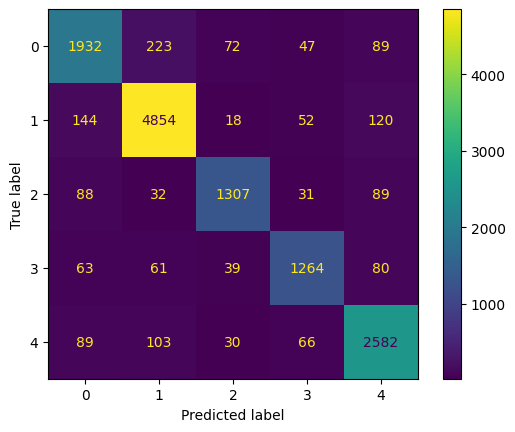

--------------------------------------------------
F1 Score: 0.8671888673605201
Test Accuracy: 0.882152133580705
Train Accuracy: 0.9126901669758812
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      2363
           1       0.92      0.93      0.93      5188
           2       0.87      0.84      0.86      1547
           3       0.86      0.84      0.85      1507
           4       0.87      0.89      0.88      2870

    accuracy                           0.88     13475
   macro avg       0.87      0.86      0.87     13475
weighted avg       0.88      0.88      0.88     13475



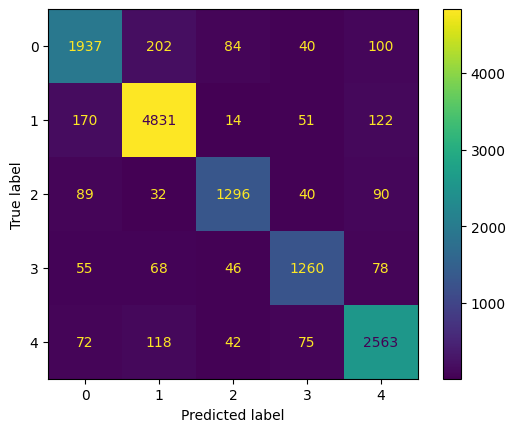

--------------------------------------------------


In [162]:
# Usando os melhores parâmetros para treinar o modelo e avaliar no conjunto de teste e aplicar cross validation

mlp = best_model
print('Treinando o modelo com os melhores parâmetros encontrados:')
print(best_model)
print('-'*50)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_train_val, y_train_val):

    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_val)
    print('F1 Score:', f1_score(y_val, y_pred, average='macro'))
    print('Test Accuracy:', accuracy_score(y_val, y_pred))
    print('Train Accuracy:', accuracy_score(y_train, mlp.predict(X_train)))
    print(classification_report(y_val, y_pred))

    # Matriz de Confusão
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    print('-'*50)

In [163]:
# Cross Validation (Outra forma de fazer o mesmo que o código acima)

cv_results = cross_validate(mlp, X_train_val, y_train_val, cv=5, n_jobs=-1, return_train_score=True)
display(pd.DataFrame(cv_results))

print('Test Accuracy:', cv_results['test_score'].mean())
print('Train Accuracy:', cv_results['train_score'].mean())

,fit_time,score_time,test_score,train_score
0,3.605321,0.003632,0.882226,0.912672
1,3.432747,0.010855,0.885640,0.910779
2,3.226376,0.004799,0.887792,0.907124
3,3.459471,0.003673,0.882226,0.913340
4,3.127733,0.006192,0.886753,0.906753


Test Accuracy: 0.8849276437847868
Train Accuracy: 0.9101335807050092


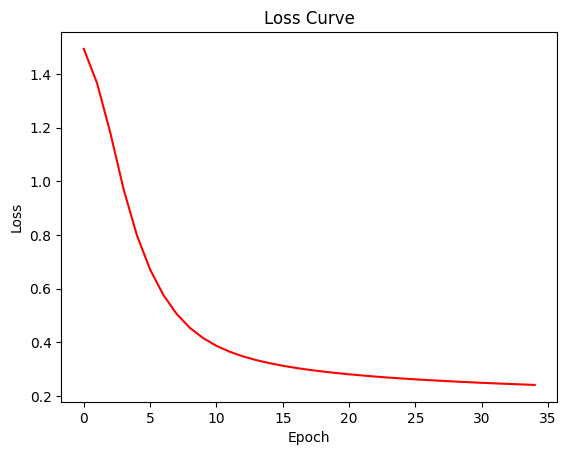

In [165]:
# Loss Curve

plt.plot(mlp.loss_curve_ , color='red' )
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

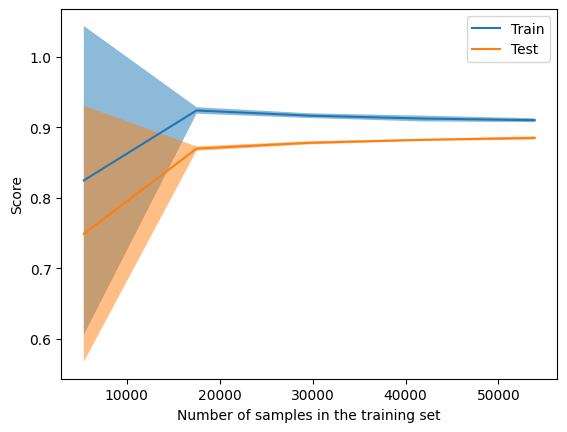

In [166]:
# Curva de Aprendizado

LearningCurveDisplay.from_estimator(mlp, X_train_val, y_train_val, cv=5, n_jobs=-1)
plt.show()

F1 Score: 0.8700332322285156
Test Accuracy: 0.8847660888150083
Train Accuracy: 0.9088979591836734
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2955
           1       0.92      0.93      0.93      6485
           2       0.88      0.83      0.86      1933
           3       0.87      0.84      0.85      1883
           4       0.87      0.90      0.88      3588

    accuracy                           0.88     16844
   macro avg       0.88      0.87      0.87     16844
weighted avg       0.88      0.88      0.88     16844



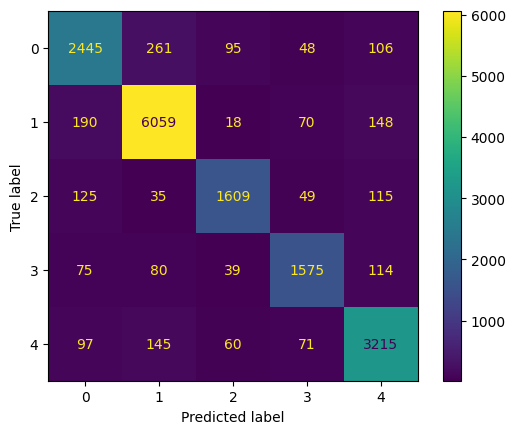

In [167]:
# Testando no conjunto de teste

mlp.fit(X_train_val, y_train_val)
y_pred = mlp.predict(X_test)

print('F1 Score:', f1_score(y_test, y_pred, average='macro')) # Macro vs Weighted vs Micro
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Train Accuracy:', accuracy_score(y_train_val, mlp.predict(X_train_val)))
print(classification_report(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

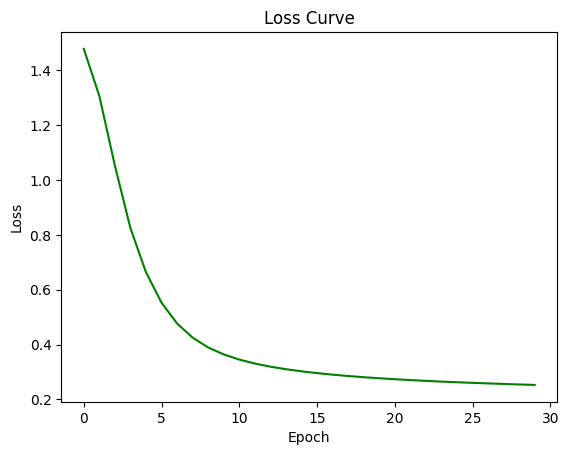

In [170]:
# Loss Curve

plt.plot(mlp.loss_curve_ , color='green')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [168]:
# Classification Report
classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

{'ENTERTAINMENT': {'precision': 0.8339017735334243,
  'recall': 0.8274111675126904,
  'f1-score': 0.8306437914047903,
  'support': 2955.0},
 'POLITICS': {'precision': 0.9208206686930092,
  'recall': 0.9343099460292984,
  'f1-score': 0.9275162648296976,
  'support': 6485.0},
 'STYLE & BEAUTY': {'precision': 0.8835804503020318,
  'recall': 0.8323848939472323,
  'f1-score': 0.8572189664358019,
  'support': 1933.0},
 'TRAVEL': {'precision': 0.8687258687258688,
  'recall': 0.8364312267657993,
  'f1-score': 0.8522727272727273,
  'support': 1883.0},
 'WELLNESS': {'precision': 0.8693888588426176,
  'recall': 0.8960423634336678,
  'f1-score': 0.8825144111995609,
  'support': 3588.0},
 'accuracy': 0.8847660888150083,
 'macro avg': {'precision': 0.8752835240193904,
  'recall': 0.8653159195377376,
  'f1-score': 0.8700332322285156,
  'support': 16844.0},
 'weighted avg': {'precision': 0.8845191655210984,
  'recall': 0.8847660888150083,
  'f1-score': 0.8844568330551366,
  'support': 16844.0}}

In [171]:
# Salvando o modelo

pkl.dump(mlp, open('neural_network_model.pkl', 'wb'))